# Úkol č. 1 - vizualizace dat a web scraping (do 20. října)

  * V rámci tohoto úkolu musíte stáhnout dat z webu (tzv. _web scraping_, velmi základní) a následně data zpracovat a vizualizovat.
  * Cílem bude stáhnout data ze serveru https://www.volby.cz týkající se voleb do zastupitelstva Vámi vybraného (většího) města, uložit tato data v tabulkovém formátu a pak vymyslet vizualizace a zobrazení dat, které umožní orientaci v těchto datech a zvýrazní zajímavé informace a zobrazit přehledně časový vývoj různých veličin.
 
> **Úkoly jsou zadány tak, aby Vám daly prostor pro invenci. Vymyslet _jak přesně_ budete úkol řešit, je důležitou součástí zadání a originalita či nápaditost bude také hodnocena!**

## Výběr zdroje dat

Vyberte si větší město, které má zastupitelstvo druhu 3 (Zastupitelstvo statutárního města) a strojově stáhněte informace o stranách a kandidátkách z následujících let:
 * [2002](https://www.volby.cz/pls/kv2002/kv12?xjazyk=CZ&xid=0), [2006](https://www.volby.cz/pls/kv2006/kv12?xjazyk=CZ&xid=0), [2010](https://www.volby.cz/pls/kv2010/kv12?xjazyk=CZ&xid=0), [2014](https://www.volby.cz/pls/kv2014/kv12?xjazyk=CZ&xid=0) a [2018](https://www.volby.cz/pls/kv2018/kv12?xjazyk=CZ&xid=0).
 

## Pokyny k vypracování

**Základní body zadání**, za jejichž (poctivé) vypracování získáte **8 bodů**:
  * Strojově stáhněte data pro vybrané město a uložte je všechny do (asi dvou) přehledných tabulek ve formátu _csv_.
  * Data musí obsahovat _alespoň_ toto:
    * Vývoj výsledků (v procentech i počtu hlasů) pro jednotlivé strany v jednotlivých letech.
    * Seznam všech kandidátů všech stran v jednotlivých letech, u kandidáta by mělo být zaznamenáno: jméno, věk v době voleb, navrhující strana, politická příslušnost, volební zisk (procento i počet hlasů), pořadí na kandidátce, pořadí zvolení, jestli získal mandát (tyto informace získáte souhrnně ve _jmenných seznamech_).
  * V druhé části Vašeho Jupyter notebooku pracujte s těmito tabulkami načtenými z _csv_ souboru (aby opravující nemusel spouštět stahování z webu).
  * Tabulky ve formátu _csv_ také odevzdejte.
  * S využitím vybraných nástrojů zpracujte data a vymyslete vizualizace a grafy, aby bylo vidět následující:
    * Časový vývoj (po rocích voleb) počtu kandidujících stran i lidí a to celkově i po jednotlivých stranách (ve volbách, kterých se daná strana účastnila).
    * Věkovou strukturu kandidátů celkově i za jednotlivé strany a vývoj této struktury během jednotlivých voleb.
    * Časový vývoj volební účasti a volebních výsledků jednotlivých stran.
    * Časový vývoj podílu kandidujících s titulem a bez titulu.

**Další body zadání** za případné další body (můžete si vybrat, maximum bodů za úkol je každopádně 12 bodů):
  * (až +2 body) U titulů se pokuste rozlišit i různé stupně vzdělání: bakalářský, magisterský, doktorský a vyšší, vojenská hodnost atp. Zkuste odhadnout i podíl žen na kandidátkách.
  * (až +4 body) Pokuste se u jednotlivých kandidátů zjistit, zda kandidovali ve více volbách. Najděte 10 nejpilnějších kandidátů a vypište jejich volební zisky a za jaké strany kandidovali.
  * (až +2 body) Najděte nějaký balíček, který Vám dovolí do Vašeho notebooku zavést interaktivní prvky, např. si vyberete v select-boxu stranu a Váš notebook zobrazí grafy pouze pro ni atp.

## Poznámky k odevzdání

  * Řiďte se pokyny ze stránky https://courses.fit.cvut.cz/BI-VZD/homeworks/index.html.
  * Odevzdejte nejen Jupyter Notebook, ale i _csv_ soubor(y) se staženými daty.
  * Opravující Vám může umožnit úkol dodělat či opravit a získat tak další body. První verze je ale důležitá a bude-li odbytá, budete za to penalizováni.

## Funkce na práci s daty
Objekty vytvořené na následnou práci s daty

In [19]:
import requests
import lxml.html as lh
import os
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
plt.rcParams['figure.figsize'] = [15, 10]

urlLinksParties = []
urlLinksMembers = []
yearsAll = [2002,2006,2010,2014,2018]
years = ['2006','2010','2014','2018']
yearsDict = {2002:0,2006:1,2010:2,2014:3,2018:4}
partyObjects = {}
memberObjects = {}

class PartyObject:
    def __init__(self):
        self.partyName = ''
        self.yearsInElections = [] #2002, 2006, 2010, 2014 or 2018
        self.numberOfVotes = []
        self.percentageOfVotes = []
    def MyPrint(self):
        print(self.partyName)
        print(self.yearsInElections)
        print(self.numberOfVotes)
        print(self.percentageOfVotes)

    def WriteIntoCSVFile(self, path):
        res = ''
        res += str(self.partyName)
        res += ';' + str(self.yearsInElections)
        res += ';' + str(self.numberOfVotes)
        res += ';' + str(self.percentageOfVotes)
        with open(path,'a') as f:
            f.write(res+'\n')

class MemberObjects:
    def __init__(self):
        self.name = ''
        self.yearsInElections = [] #2002, 2006, 2010, 2014 or 2018
        self.partyName = []
        self.numberOfVotes = []
        self.percentageOfVotes = []
        self.rankBeforeElection = []
        self.rankAfterElection = []
        self.AgeDuringSaidElection = []
        self.receivedMandate = []
        self.hasTitle = 0

    def MyPrint(self):
        print(self.name)
        print('strany za ktere kandidoval/a:',str(self.partyName).strip('[]'))
        print('Roky kdy kandidoval/a:',str(self.yearsInElections).strip('[]'))
        print('Pocet hlasu:',str(self.numberOfVotes).strip('[]'))
        print('Procenta hlasu:',str(self.percentageOfVotes).strip('[]'))

    def WriteIntoCSVFile(self,path):
        res = ''
        res += self.name
        res += ';' + str(self.yearsInElections)
        res += ';' + str(self.partyName)
        res += ';' + str(self.numberOfVotes)
        res += ';' + str(self.percentageOfVotes)
        res += ';' + str(self.rankBeforeElection)
        res += ';' + str(self.rankAfterElection)
        res += ';' + str(self.AgeDuringSaidElection)
        res += ';' + str(self.receivedMandate)
        res += ';' + str(self.hasTitle)
        with open(path,'a') as f:
            f.write(res+'\n')

def CreateURLLinks():
    urlLinksParties.append('https://www.volby.cz/pls/kv2002/kv1111?xjazyk=CZ&xid=0&xdz=3&xnumnuts=5103&xobec=563889&xobecnaz=LIBEREC')
    for year in years:
        link = 'https://www.volby.cz/pls/kv'+str(year)+'/kv1111?xjazyk=CZ&xid=0&xdz=3&xnumnuts=5103&xobec=563889&xstat=0&xvyber=0'
        urlLinksParties.append(link)

    for year in yearsAll:
        link = 'https://www.volby.cz/pls/kv'+str(year)+'/kv21111?xjazyk=CZ&xid=0&xv=11&xdz=3&xnumnuts=5103&xobec=563889&xstrana=0'
        urlLinksMembers.append(link)
    

def GetPartyResults(link,indexYear):
    page = requests.get(link)
    text = page.text

    doc = lh.fromstring(page.content)
    #Parse data that are stored between <tr>..</tr> of HTML
    tr_elements = doc.xpath('//tr')

    for index in range(len(tr_elements)):
        i=0
        partyName = ''
        for t in tr_elements[index]:
            if index>=5:
                text =t.text_content()
                text = text.replace(u'\xa0', u'')
                if i==1: #name
                    if text not in partyObjects.keys():
                        partyObjects[text] = PartyObject()
                        partyObjects[text].partyName = text
                    partyObjects[text].yearsInElections.append(yearsAll[indexYear])
                    partyName = text
                if i==2: #total votes
                    partyObjects[partyName].numberOfVotes.append(int(str(text)))                
                if i==3: #percentage votes
                    text = text.replace(u',', u'.')
                    partyObjects[partyName].percentageOfVotes.append(float(text))
                i += 1


tituly = ['MUDr.','Ing.','PhD.','Bc.','Mgr.','CSc.','Ph.D.','prof.','PhDr.','MVDr.','MPA','RNDr.','doc.','MBA','PharmDr.','JUDr.','PaedDr.','arch.','DiS.']

def GetMemberResults(link,indexYear):
    page = requests.get(link)
    text = page.text

    doc = lh.fromstring(page.content)
    #Parse data that are stored between <tr>..</tr> of HTML
    tr_elements = doc.xpath('//tr')

    for index in range(len(tr_elements)):
        if index >= 2:
            i = 0
            if indexYear == 0:
                i = 1

            name = tr_elements[index][3].text_content()
            hasTitle = 0
            for titul in tituly:
                if titul in name:
                    hasTitle = 1
                name = name.replace(titul, "")
            name = name.replace(' '," ")
            nameKey = name + str(int(yearsAll[indexYear])-int(tr_elements[index][4+i].text_content()))
            if nameKey not in memberObjects.keys():
                memberObjects[nameKey] = MemberObjects()
                memberObjects[nameKey].name = name

            memberObjects[nameKey].yearsInElections.append(yearsAll[indexYear])
            memberObjects[nameKey].partyName.append(tr_elements[index][1].text_content())

            if indexYear == 0:
                titles = tr_elements[index][4].text_content()
                if len(titles) > 1:
                    memberObjects[nameKey].hasTitle = 1

            if hasTitle == 1:
                memberObjects[nameKey].hasTitle = hasTitle
            numberOfVotes = tr_elements[index][7+i].text_content()
            numberOfVotes = numberOfVotes.replace(u'\xa0', u'')
            memberObjects[nameKey].numberOfVotes.append(numberOfVotes)
            percentage = tr_elements[index][8+i].text_content()
            percentage = percentage.replace(u',', u'.')
            memberObjects[nameKey].percentageOfVotes.append(percentage)
            memberObjects[nameKey].rankAfterElection.append(tr_elements[index][9+i].text_content())
            memberObjects[nameKey].AgeDuringSaidElection.append(tr_elements[index][4+i].text_content())
            memberObjects[nameKey].rankBeforeElection.append(tr_elements[index][2].text_content())
            mandate = tr_elements[index][10+i].text_content()
            mandate = 'YES' if mandate == '*' else 'NO'
            memberObjects[nameKey].receivedMandate.append(mandate)


csvPeople = 'people.csv'
csvParties = 'parties.csv'
def PartOne(): # Load data into csv files
    CreateURLLinks()
    for cnt, link in enumerate(urlLinksParties):
        GetPartyResults(link, cnt)
    for cnt, link in enumerate(urlLinksMembers):
        GetMemberResults(link, cnt)

    if os.path.exists(csvPeople):
        os.remove(csvPeople)

    for key in memberObjects.keys():
        memberObjects[key].WriteIntoCSVFile(csvPeople)

    if os.path.exists(csvParties):
        os.remove(csvParties)

    for key in partyObjects.keys():
        partyObjects[key].WriteIntoCSVFile(csvParties)

## Načtení dat z csv souboru

In [20]:
with open(csvPeople,'r') as f:
    lines = [line.rstrip('\n') for line in f]
for line in lines:
    arr = line.split(';')
    memberObjects[arr[0]] = MemberObjects()
    memberObjects[arr[0]].name = arr[0]
    memberObjects[arr[0]].yearsInElections = eval(arr[1])
    memberObjects[arr[0]].partyName = eval(arr[2])
    memberObjects[arr[0]].numberOfVotes = eval(arr[3])
    memberObjects[arr[0]].percentageOfVotes = eval(arr[4])
    memberObjects[arr[0]].rankBeforeElection = eval(arr[5])
    memberObjects[arr[0]].rankAfterElection = eval(arr[6])
    memberObjects[arr[0]].AgeDuringSaidElection = eval(arr[7])
    memberObjects[arr[0]].receivedMandate = eval(arr[8])
    memberObjects[arr[0]].hasTitle = arr[9]


with open(csvParties,'r') as f:
    lines = [line.rstrip('\n') for line in f]
for line in lines:
    arr = line.split(';')
    partyObjects[arr[0]] = PartyObject()
    partyObjects[arr[0]].partyName = arr[0]
    partyObjects[arr[0]].yearsInElections = eval(arr[1])
    partyObjects[arr[0]].numberOfVotes = eval(arr[2])
    partyObjects[arr[0]].percentageOfVotes = eval(arr[3])

## Časový vývoj počtu stran a lidí
Časový vývoj (po rocích voleb) počtu kandidujících stran i lidí a to celkově i po jednotlivých stranách (ve volbách, kterých se daná strana účastnila).

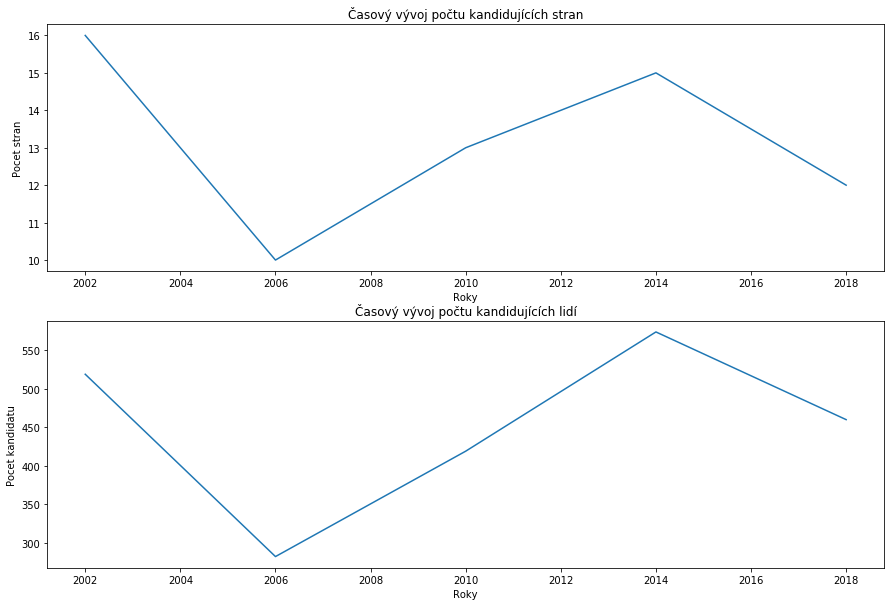

In [21]:
nOfPartiesPerYear = [0 for i in range(len(yearsAll))]
nOfPeoplePerYear = [0 for i in range(len(yearsAll))]
for i in range(len(nOfPeoplePerYear)):
    for key in memberObjects.keys():
        if yearsAll[i] in memberObjects[key].yearsInElections:
            nOfPeoplePerYear[i] += 1

    for key in partyObjects.keys():
        if yearsAll[i] in partyObjects[key].yearsInElections:
            nOfPartiesPerYear[i] += 1

plt.subplot(211)
plt.plot(yearsAll,nOfPartiesPerYear)
plt.xlabel('Roky')
plt.ylabel('Pocet stran')
plt.title('Časový vývoj počtu kandidujících stran')

plt.subplot('212')
plt.plot(yearsAll, nOfPeoplePerYear)
plt.xlabel('Roky')
plt.ylabel('Pocet kandidatu')
plt.title('Časový vývoj počtu kandidujících lidí')
plt.show()

## Věková struktura
Věkovou strukturu kandidátů celkově i za jednotlivé strany a vývoj této struktury během jednotlivých voleb.

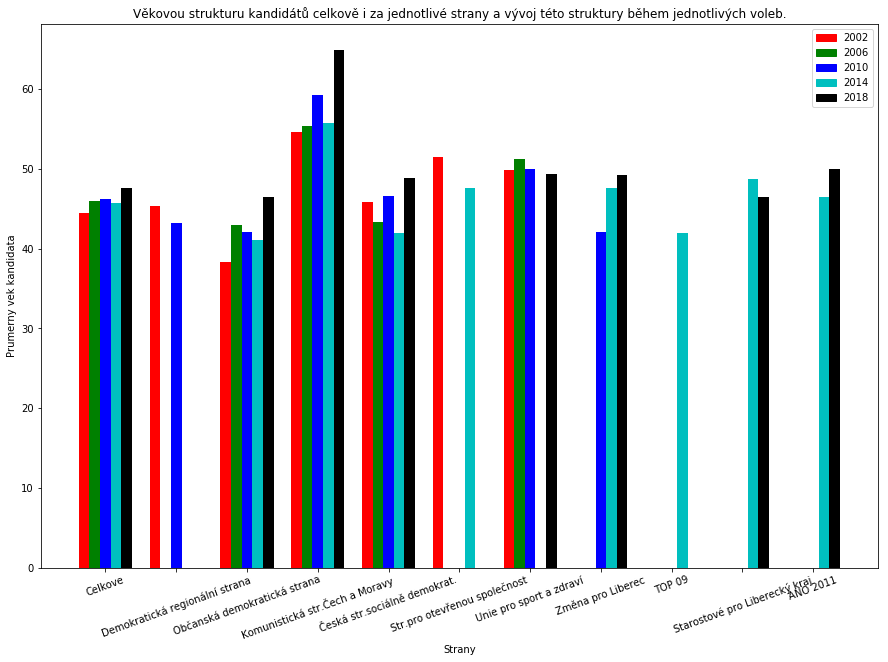

In [22]:
PartyYears = [[0 for j in range(11)] for i in range(len(yearsAll))]
countPartyYears = [[0 for j in range(11)] for i in range(len(yearsAll))]
partyNames = ['Celkove']
width = 0.15
widths = [-2 * width, -1 * width, 0, 1 * width, 2 * width]

for key in partyObjects.keys():
    if partyObjects[key].partyName not in partyNames and len(partyObjects[key].yearsInElections) > 1:
        partyNames.append(partyObjects[key].partyName)

for cnt, key in enumerate(memberObjects.keys()):
    for cnt2, year in enumerate(memberObjects[key].yearsInElections):
        PartyYears[yearsDict[year]][0] += int(memberObjects[key].AgeDuringSaidElection[cnt2])
        countPartyYears[yearsDict[year]][0] += 1

    for i in range(len(partyNames)):
        for cnt2, year in enumerate(memberObjects[key].yearsInElections):
            if partyNames[i] == memberObjects[key].partyName[cnt2]:
                PartyYears[yearsDict[year]][i] += int(memberObjects[key].AgeDuringSaidElection[cnt2])
                countPartyYears[yearsDict[year]][i] += 1



for i in range(len(PartyYears)):
    for j in range(len(PartyYears[i])):
        if countPartyYears[i][j] != 0:
            PartyYears[i][j] /= float(countPartyYears[i][j])

import numpy as np
ind = np.arange(len(PartyYears[0]))
colors = ['r','g','b','c','k']
patchesList1 = []

for i in range(len(PartyYears)):
    plt.bar(ind+widths[i], PartyYears[i], width,color=colors[i])
    patchesList1.append(mpatches.Patch(color=colors[i], label=str(yearsAll[i])))

plt.legend(handles=patchesList1)
plt.xticks(ind,partyNames, rotation=20)
plt.xlabel('Strany')
plt.ylabel('Prumerny vek kandidata')
plt.title('Věkovou strukturu kandidátů celkově i za jednotlivé strany a vývoj této struktury během jednotlivých voleb.')
plt.show()

## Časový vývoj výsledků voleb
Časový vývoj volebních výsledků jednotlivých stran.

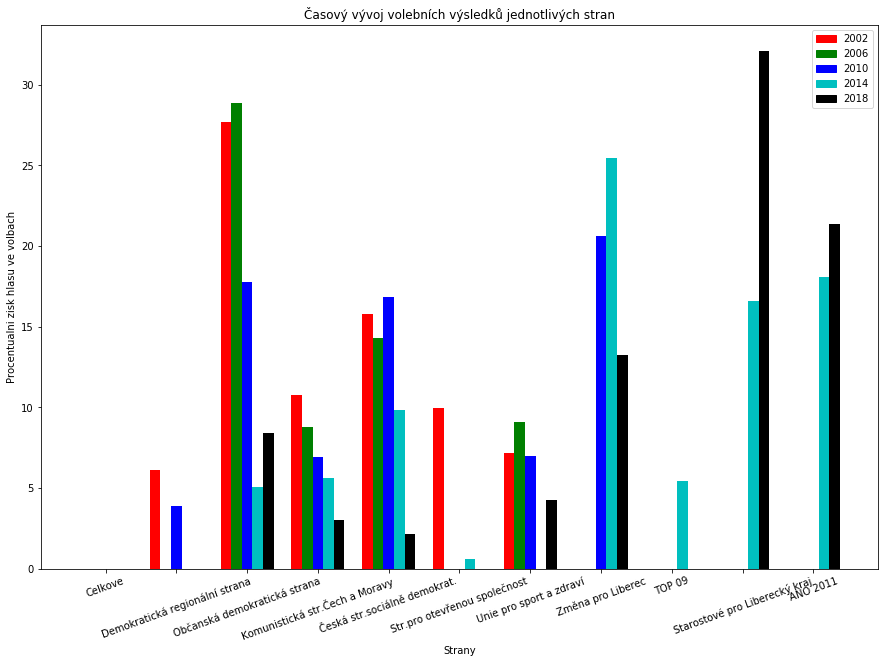

In [23]:
percentagesYears = [[0 for j in range(11)] for i in range(len(yearsAll))]

for cnt, key in enumerate(partyNames):
    if key in partyObjects.keys() and len(partyObjects[key].yearsInElections) > 1:
        for j in range(len(partyObjects[key].yearsInElections)):
            percentagesYears[yearsDict[partyObjects[key].yearsInElections[j]]][cnt] = partyObjects[key].percentageOfVotes[j]

for i in range(len(percentagesYears)):
    plt.bar(ind+widths[i], percentagesYears[i], width,color=colors[i])

plt.title('Časový vývoj volebních výsledků jednotlivých stran')
plt.legend(handles=patchesList1)
plt.xticks(ind, partyNames, rotation=20)
plt.xlabel('Strany')
plt.ylabel('Procentualni zisk hlasu ve volbach')
plt.show()

## Časový vývoj volební účasti

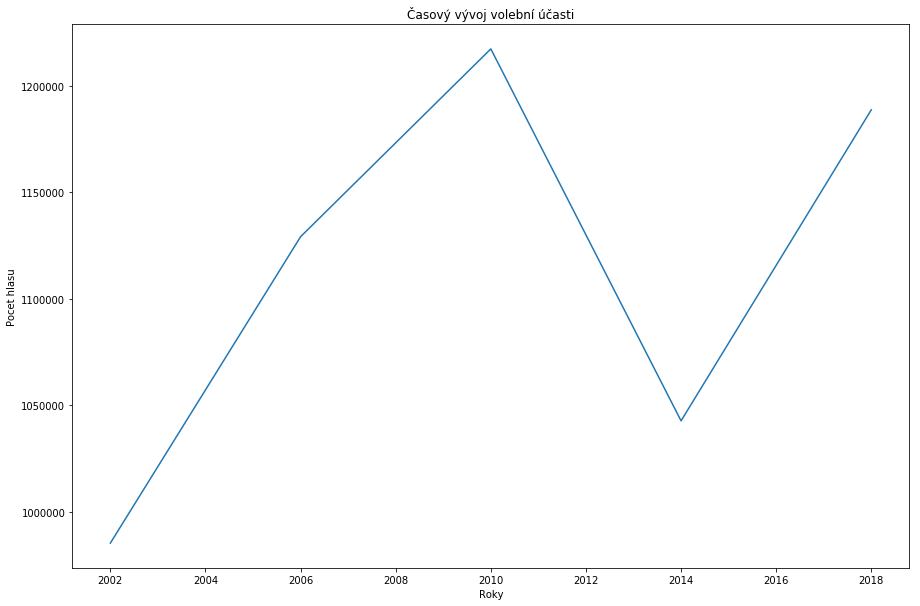

In [24]:
nOfPeople = [0 for i in range(len(yearsAll))]
for key in partyObjects.keys():
    for i in range(len(partyObjects[key].yearsInElections)):
        nOfPeople[yearsDict[partyObjects[key].yearsInElections[i]]] += partyObjects[key].numberOfVotes[i]

plt.plot(yearsAll,nOfPeople)
plt.xlabel('Roky')
plt.ylabel('Pocet hlasu')
plt.title('Časový vývoj volební účasti')
plt.show()

## Časový vývoj podílu kandidujících s titulem a bez titulu

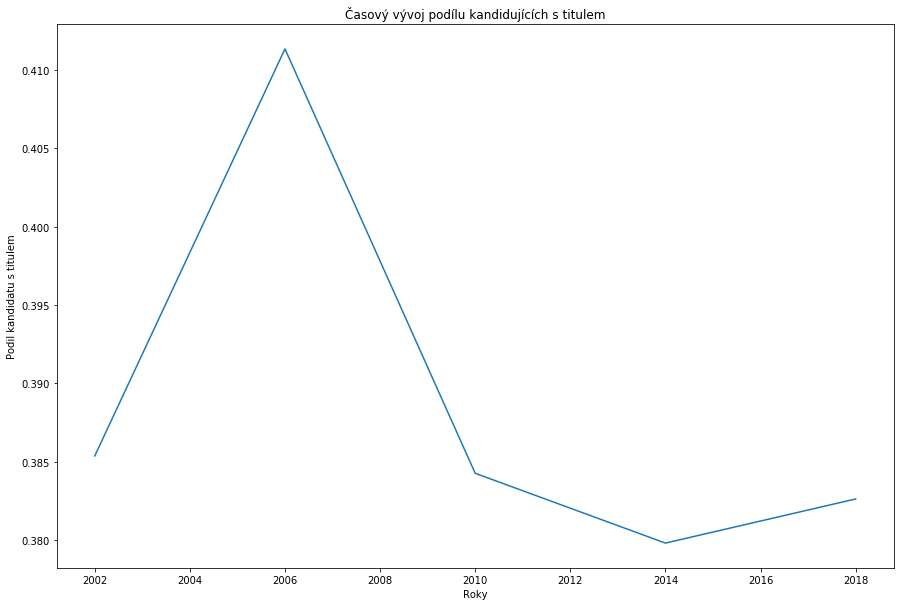

In [25]:
nOfHasTitle = [0 for i in range(len(yearsAll))]
nOfHasNotTitle = [0 for i in range(len(yearsAll))]
percentageTitle = [0 for i in range(len(yearsAll))]
for i in range(len(nOfHasTitle)):
    for key in memberObjects.keys():
        if yearsAll[i] in memberObjects[key].yearsInElections:
            if memberObjects[key].hasTitle == '1':
                nOfHasTitle[i] += 1
            else:
                nOfHasNotTitle[i] += 1
    percentageTitle[i] = nOfHasTitle[i] / float(nOfHasTitle[i] + nOfHasNotTitle[i])

plt.plot(yearsAll,percentageTitle)
plt.xlabel('Roky')
plt.ylabel('Podil kandidatu s titulem')
plt.title('Časový vývoj podílu kandidujících s titulem')
plt.show()

## Nejpilnější kandidáti
Pokuste se u jednotlivých kandidátů zjistit, zda kandidovali ve více volbách. Najděte 10 nejpilnějších kandidátů a vypište jejich volební zisky a za jaké strany kandidovali.

In [26]:
print("Nejpilnejsi kandidati")
print()
print()
arr = []
for key in memberObjects.keys():
    arr.append([len(memberObjects[key].yearsInElections),memberObjects[key].name])
arr.sort(reverse=True)
arr = arr[:10]
for cnt, item in enumerate(arr):
    print(str(cnt+1)+'.')
    memberObjects[item[1]].MyPrint()

Nejpilnejsi kandidati


1.
Šedivý Alexandr
strany za ktere kandidoval/a: 'Komunistická str.Čech a Moravy', 'Komunistická str.Čech a Moravy', 'Komunistická str.Čech a Moravy', 'Komunistická str.Čech a Moravy', 'Komunistická str.Čech a Moravy'
Roky kdy kandidoval/a: 2002, 2006, 2010, 2014, 2018
Pocet hlasu: '2741', '2549', '2173', '1523', '958'
Procenta hlasu: '2.58', '2.57', '2.58', '2.61', '2.66'
2.
Zelinková Ludmila
strany za ktere kandidoval/a: 'Komunistická str.Čech a Moravy', 'Komunistická str.Čech a Moravy', 'Komunistická str.Čech a Moravy', 'Komunistická str.Čech a Moravy', 'Komunistická str.Čech a Moravy'
Roky kdy kandidoval/a: 2002, 2006, 2010, 2014, 2018
Pocet hlasu: '2829', '2545', '2210', '1526', '929'
Procenta hlasu: '2.67', '2.57', '2.62', '2.61', '2.58'
3.
Vacková Jana
strany za ktere kandidoval/a: 'Unie pro sport a zdraví', 'Unie pro sport a zdraví', 'Unie pro sport a zdraví', 'PRO Sport a Zdraví', 'Unie pro sport a zdraví'
Roky kdy kandidoval/a: 2002, 2006, 2010, 2014, 

## Podíl žen na kandidátkách.

In [27]:
pocetZen = 0
koncovkyZenske = ['ová ','atá ','ná ','ká ']
for key in memberObjects.keys():
    for koncovka in koncovkyZenske:
        if koncovka in memberObjects[key].name:
            pocetZen += 1
            break

print('Odhadnute procento zen:',pocetZen/len(list(memberObjects.keys())) * 100)

Odhadnute procento zen: 32.87749287749288
